# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=40,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_13-47-43/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5223 | MulticlassF1Score=0.0648
Batch-30 : CrossEntropyLoss=2.4565 | MulticlassF1Score=0.1575
Batch-45 : CrossEntropyLoss=2.4654 | MulticlassF1Score=0.1899
Batch-60 : CrossEntropyLoss=2.4763 | MulticlassF1Score=0.2084
Batch-75 : CrossEntropyLoss=2.4533 | MulticlassF1Score=0.2178
Batch-90 : CrossEntropyLoss=2.5065 | MulticlassF1Score=0.2242
Batch-105: CrossEntropyLoss=2.4593 | MulticlassF1Score=0.2300
Batch-120: CrossEntropyLoss=2.4622 | MulticlassF1Score=0.2339
Batch-135: CrossEntropyLoss=2.4855 | MulticlassF1Score=0.2363
Batch-150: CrossEntropyLoss=2.4669 | MulticlassF1Score=0.2398
Batch-165: CrossEntropyLoss=2.4463 | MulticlassF1Score=0.2495
Batch-180: CrossEntropyLoss=2.4646 | MulticlassF1Score=0.2590
Batch-195: CrossEntropyLoss=2.4619 | MulticlassF1Score=0.2682
Batch-210: CrossEntropyLoss=2.4333 | MulticlassF1Score=0.2765
Batch-225: CrossEntropyLoss=2.4150 | MulticlassF1Score=0.2890
Batch-226: CrossEntropyLoss=2.4502 | MulticlassF1Score=0.2896

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4305 | MulticlassF1Score=0.4722
Batch-30 : CrossEntropyLoss=2.3984 | MulticlassF1Score=0.4705
Batch-45 : CrossEntropyLoss=2.4005 | MulticlassF1Score=0.4731
Batch-60 : CrossEntropyLoss=2.4101 | MulticlassF1Score=0.4727
Batch-63 : CrossEntropyLoss=2.4192 | MulticlassF1Score=0.4725

Training   : Mean CrossEntropyLoss = 2.4757 | Mean MulticlassF1Score = 0.2159
Validation : Mean CrossEntropyLoss = 2.4134 | Mean MulticlassF1Score = 0.4717

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4024 | MulticlassF1Score=0.4783
Batch-30 : CrossEntropyLoss=2.4103 | MulticlassF1Score=0.4770
Batch-45 : CrossEntropyLoss=2.4166 | MulticlassF1Score=0.4744
Batch-60 : CrossEntropyLoss=2.4114 | MulticlassF1Score=0.4750
Batch-75 : CrossEntropyLoss=2.4297 | MulticlassF1Score=0.4766
Batch-90 : CrossEntropyLoss=2.3742 | MulticlassF1Score=0.4902
Batch-105: CrossEntropyLoss=2.3744 | MulticlassF1Score=0.5041
Batch-120: CrossEntropyLoss=2.3709 | MulticlassF1Score=0.5134
Batch-135: CrossEntropyLoss=2.3797 | MulticlassF1Score=0.5227
Batch-150: CrossEntropyLoss=2.3888 | MulticlassF1Score=0.5301
Batch-165: CrossEntropyLoss=2.3640 | MulticlassF1Score=0.5366
Batch-180: CrossEntropyLoss=2.3819 | MulticlassF1Score=0.5412
Batch-195: CrossEntropyLoss=2.3412 | MulticlassF1Score=0.5458
Batch-210: CrossEntropyLoss=2.3579 | MulticlassF1Score=0.5547
Batch-225: CrossEntropyLoss=2.3512 | MulticlassF1Score=0.5621
Batch-226: CrossEntropyLoss=2.3496 | MulticlassF1Score=0.5622

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3510 | MulticlassF1Score=0.6646
Batch-30 : CrossEntropyLoss=2.3514 | MulticlassF1Score=0.6661
Batch-45 : CrossEntropyLoss=2.3496 | MulticlassF1Score=0.6695
Batch-60 : CrossEntropyLoss=2.3426 | MulticlassF1Score=0.6689
Batch-63 : CrossEntropyLoss=2.3441 | MulticlassF1Score=0.6697

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3840 | Mean MulticlassF1Score = 0.5095
Validation : Mean CrossEntropyLoss = 2.3516 | Mean MulticlassF1Score = 0.6677

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3412 | MulticlassF1Score=0.6756
Batch-30 : CrossEntropyLoss=2.3581 | MulticlassF1Score=0.6745
Batch-45 : CrossEntropyLoss=2.3408 | MulticlassF1Score=0.6754
Batch-60 : CrossEntropyLoss=2.3667 | MulticlassF1Score=0.6771
Batch-75 : CrossEntropyLoss=2.3678 | MulticlassF1Score=0.6764
Batch-90 : CrossEntropyLoss=2.3476 | MulticlassF1Score=0.6791
Batch-105: CrossEntropyLoss=2.3368 | MulticlassF1Score=0.6868
Batch-120: CrossEntropyLoss=2.3187 | MulticlassF1Score=0.6941
Batch-135: CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7028
Batch-150: CrossEntropyLoss=2.3303 | MulticlassF1Score=0.7105
Batch-165: CrossEntropyLoss=2.3135 | MulticlassF1Score=0.7177
Batch-180: CrossEntropyLoss=2.3211 | MulticlassF1Score=0.7233
Batch-195: CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7287
Batch-210: CrossEntropyLoss=2.3148 | MulticlassF1Score=0.7333
Batch-225: CrossEntropyLoss=2.3147 | MulticlassF1Score=0.7371
Batch-226: CrossEntropyLoss=2.3121 | MulticlassF1Score=0.7373

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3113 | MulticlassF1Score=0.7885
Batch-30 : CrossEntropyLoss=2.3344 | MulticlassF1Score=0.7865
Batch-45 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.7880
Batch-60 : CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7902
Batch-63 : CrossEntropyLoss=2.3188 | MulticlassF1Score=0.7898

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3300 | Mean MulticlassF1Score = 0.6977
Validation : Mean CrossEntropyLoss = 2.3139 | Mean MulticlassF1Score = 0.7893

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7930
Batch-30 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7932
Batch-45 : CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7923
Batch-60 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7933
Batch-75 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.7927
Batch-90 : CrossEntropyLoss=2.3181 | MulticlassF1Score=0.7912
Batch-105: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.7916
Batch-120: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7915
Batch-135: CrossEntropyLoss=2.3196 | MulticlassF1Score=0.7930
Batch-150: CrossEntropyLoss=2.3163 | MulticlassF1Score=0.7935
Batch-165: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.7940
Batch-180: CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7939
Batch-195: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7942
Batch-210: CrossEntropyLoss=2.3179 | MulticlassF1Score=0.7944
Batch-225: CrossEntropyLoss=2.3165 | MulticlassF1Score=0.7942
Batch-226: CrossEntropyLoss=2.3160 | MulticlassF1Score=0.7941

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7875
Batch-30 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7918
Batch-45 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.7932
Batch-60 : CrossEntropyLoss=2.3235 | MulticlassF1Score=0.7929
Batch-63 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.7936

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3119 | Mean MulticlassF1Score = 0.7934
Validation : Mean CrossEntropyLoss = 2.3122 | Mean MulticlassF1Score = 0.7899

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7974
Batch-30 : CrossEntropyLoss=2.3111 | MulticlassF1Score=0.7983
Batch-45 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7986
Batch-60 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.7983
Batch-75 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.7979
Batch-90 : CrossEntropyLoss=2.3120 | MulticlassF1Score=0.7984
Batch-105: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.7983
Batch-120: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.7982
Batch-135: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.7975
Batch-150: CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7980
Batch-165: CrossEntropyLoss=2.3150 | MulticlassF1Score=0.7990
Batch-180: CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8001
Batch-195: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8011
Batch-210: CrossEntropyLoss=2.3142 | MulticlassF1Score=0.8013
Batch-225: CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8019
Batch-226: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8020

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8011
Batch-30 : CrossEntropyLoss=2.3131 | MulticlassF1Score=0.8021
Batch-45 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8046
Batch-60 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.8069
Batch-63 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8071

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3092 | Mean MulticlassF1Score = 0.7984
Validation : Mean CrossEntropyLoss = 2.3079 | Mean MulticlassF1Score = 0.8019

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8161
Batch-30 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8164
Batch-45 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8141
Batch-60 : CrossEntropyLoss=2.3108 | MulticlassF1Score=0.8121
Batch-75 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8111
Batch-90 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8124
Batch-105: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.8130
Batch-120: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8152
Batch-135: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8155
Batch-150: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8156
Batch-165: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8161
Batch-180: CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8162
Batch-195: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8158
Batch-210: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8159
Batch-225: CrossEntropyLoss=2.3156 | MulticlassF1Score=0.8157
Batch-226: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.8157

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3159 | MulticlassF1Score=0.8120
Batch-30 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8120
Batch-45 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8129
Batch-60 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8153
Batch-63 : CrossEntropyLoss=2.3157 | MulticlassF1Score=0.8152

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3047 | Mean MulticlassF1Score = 0.8148
Validation : Mean CrossEntropyLoss = 2.3055 | Mean MulticlassF1Score = 0.8134

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3140 | MulticlassF1Score=0.8210
Batch-30 : CrossEntropyLoss=2.3109 | MulticlassF1Score=0.8201
Batch-45 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8224
Batch-60 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8259
Batch-75 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8285
Batch-90 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8297
Batch-105: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8310
Batch-120: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8316
Batch-135: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8326
Batch-150: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8332
Batch-165: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8337
Batch-180: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8342
Batch-195: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8351
Batch-210: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8359
Batch-225: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8362
Batch-226: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8363

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8315
Batch-30 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8333
Batch-45 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8353
Batch-60 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8351
Batch-63 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8358

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2984 | Mean MulticlassF1Score = 0.8300
Validation : Mean CrossEntropyLoss = 2.2989 | Mean MulticlassF1Score = 0.8329

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8478
Batch-30 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8451
Batch-45 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8415
Batch-60 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8426
Batch-75 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8429
Batch-90 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8438
Batch-105: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8440
Batch-120: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8440
Batch-135: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8448
Batch-150: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8457
Batch-165: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8457
Batch-180: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8455
Batch-195: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8448
Batch-210: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8448
Batch-225: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8446
Batch-226: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8446

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8401
Batch-30 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8419
Batch-45 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8416
Batch-60 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8412
Batch-63 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8408

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2958 | Mean MulticlassF1Score = 0.8450
Validation : Mean CrossEntropyLoss = 2.2973 | Mean MulticlassF1Score = 0.8408

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8432
Batch-30 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8459
Batch-45 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8478
Batch-60 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8485
Batch-75 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8488
Batch-90 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8498
Batch-105: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8509
Batch-120: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8522
Batch-135: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8537
Batch-150: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8545
Batch-165: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8553
Batch-180: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8562
Batch-195: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8568
Batch-210: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8567
Batch-225: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8573
Batch-226: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8574

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8547
Batch-30 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8564
Batch-45 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8577
Batch-60 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8577
Batch-63 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8587

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2920 | Mean MulticlassF1Score = 0.8516
Validation : Mean CrossEntropyLoss = 2.2920 | Mean MulticlassF1Score = 0.8588

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8615
Batch-30 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8645
Batch-45 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8658
Batch-60 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8652
Batch-75 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8658
Batch-90 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8659
Batch-105: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8662
Batch-120: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8660
Batch-135: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8659
Batch-150: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8651
Batch-165: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8651
Batch-180: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8651
Batch-195: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8648
Batch-210: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8650
Batch-225: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8655
Batch-226: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8656

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8592
Batch-30 : CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8559
Batch-45 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8570
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8591
Batch-63 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8593

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2893 | Mean MulticlassF1Score = 0.8650
Validation : Mean CrossEntropyLoss = 2.2916 | Mean MulticlassF1Score = 0.8578

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8721
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8703
Batch-45 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8682
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8679
Batch-75 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8679
Batch-90 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8671
Batch-105: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8671
Batch-120: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8664
Batch-135: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8668
Batch-150: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8663
Batch-165: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8664
Batch-180: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8670
Batch-195: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8670
Batch-210: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8667
Batch-225: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8670
Batch-226: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8608
Batch-30 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8591
Batch-45 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8584
Batch-60 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8586
Batch-63 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8584

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2888 | Mean MulticlassF1Score = 0.8680
Validation : Mean CrossEntropyLoss = 2.2918 | Mean MulticlassF1Score = 0.8596

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8655
Batch-30 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8640
Batch-45 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8650
Batch-60 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8661
Batch-75 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8684
Batch-90 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8672
Batch-105: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8675
Batch-120: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8676
Batch-135: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8676
Batch-150: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8675
Batch-165: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8678
Batch-180: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8679
Batch-195: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8679
Batch-210: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8679
Batch-225: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8683
Batch-226: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8683

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8596
Batch-30 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8593
Batch-45 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8594
Batch-60 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8600
Batch-63 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8599

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2884 | Mean MulticlassF1Score = 0.8667
Validation : Mean CrossEntropyLoss = 2.2912 | Mean MulticlassF1Score = 0.8609

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8695
Batch-30 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8688
Batch-45 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8680
Batch-60 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8686
Batch-75 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8685
Batch-90 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8686
Batch-105: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8688
Batch-120: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8690
Batch-135: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8686
Batch-150: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8683
Batch-165: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8684
Batch-180: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8687
Batch-195: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8687
Batch-210: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8693
Batch-225: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8696
Batch-226: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8618
Batch-30 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8601
Batch-45 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8598
Batch-60 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8606
Batch-63 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8605

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2879 | Mean MulticlassF1Score = 0.8683
Validation : Mean CrossEntropyLoss = 2.2911 | Mean MulticlassF1Score = 0.8616

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8733
Batch-30 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8822
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8869
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8908
Batch-75 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8908
Batch-90 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8918
Batch-105: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8927
Batch-120: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8929
Batch-135: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8931
Batch-150: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8936
Batch-165: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8939
Batch-180: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8944
Batch-195: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8946
Batch-210: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8950
Batch-225: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8952
Batch-226: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8952

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8933
Batch-30 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8883
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8888
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8886
Batch-63 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8888

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8900
Validation : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8912

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9047
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9038
Batch-45 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.9028
Batch-60 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.9030
Batch-75 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9021
Batch-90 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9015
Batch-105: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9019
Batch-120: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9013
Batch-135: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9009
Batch-150: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9007
Batch-165: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.9007
Batch-180: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9007
Batch-195: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9006
Batch-210: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9007
Batch-225: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.9003
Batch-226: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9003

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8898
Batch-30 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8889
Batch-45 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8903
Batch-60 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8905
Batch-63 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8905

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2787 | Mean MulticlassF1Score = 0.9015
Validation : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8890

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9010
Batch-30 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.9002
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9007
Batch-60 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.9023
Batch-75 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9020
Batch-90 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9022
Batch-105: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9018
Batch-120: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9015
Batch-135: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9017
Batch-150: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9016
Batch-165: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9016
Batch-180: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9017
Batch-195: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9018
Batch-210: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9022
Batch-225: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9022
Batch-226: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9022

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8921
Batch-30 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8888
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8911
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8909
Batch-63 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8907

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2780 | Mean MulticlassF1Score = 0.9017
Validation : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8911

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9061
Batch-30 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.9035
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9041
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9053
Batch-75 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9051
Batch-90 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9052
Batch-105: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9048
Batch-120: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9051
Batch-135: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9043
Batch-150: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9037
Batch-165: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9043
Batch-180: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9044
Batch-195: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9042
Batch-210: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9042
Batch-225: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9041
Batch-226: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9042

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8958
Batch-30 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8921
Batch-45 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8911
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8917
Batch-63 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8914

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2774 | Mean MulticlassF1Score = 0.9046
Validation : Mean CrossEntropyLoss = 2.2815 | Mean MulticlassF1Score = 0.8929

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9059
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9078
Batch-45 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9062
Batch-60 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9055
Batch-75 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9062
Batch-90 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9063
Batch-105: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9058
Batch-120: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9059
Batch-135: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9056
Batch-150: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9054
Batch-165: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9054
Batch-180: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9059
Batch-195: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9056
Batch-210: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9059
Batch-225: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9055
Batch-226: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9056

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8891
Batch-30 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8923
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8930
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8921
Batch-63 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8921

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2769 | Mean MulticlassF1Score = 0.9058
Validation : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8918

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9054
Batch-30 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9047
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9061
Batch-60 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.9063
Batch-75 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.9065
Batch-90 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.9063
Batch-105: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9064
Batch-120: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9063
Batch-135: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9064
Batch-150: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9066
Batch-165: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9067
Batch-180: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9066
Batch-195: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9067
Batch-210: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9068
Batch-225: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9069
Batch-226: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9069

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8864
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8895
Batch-45 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8923
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8913
Batch-63 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8917

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9063
Validation : Mean CrossEntropyLoss = 2.2815 | Mean MulticlassF1Score = 0.8893

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9088
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9078
Batch-45 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9069
Batch-60 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9073
Batch-75 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9079
Batch-90 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9077
Batch-105: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9082
Batch-120: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9080
Batch-135: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9079
Batch-150: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9078
Batch-165: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9077
Batch-180: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9077
Batch-195: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9076
Batch-210: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9073
Batch-225: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9074
Batch-226: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9074

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8904
Batch-30 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8914
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8918
Batch-60 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8913
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8919

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2763 | Mean MulticlassF1Score = 0.9079
Validation : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8920

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9099
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9090
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9101
Batch-60 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9099
Batch-75 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9107
Batch-90 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9101
Batch-105: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9099
Batch-120: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9090
Batch-135: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.9075
Batch-150: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9077
Batch-165: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9079
Batch-180: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9077
Batch-195: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9077
Batch-210: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9078
Batch-225: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9080
Batch-226: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9081

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8931
Batch-30 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8928
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8913
Batch-60 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8917
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8921

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2760 | Mean MulticlassF1Score = 0.9090
Validation : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8923

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9117
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9089
Batch-45 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9075
Batch-60 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9099
Batch-75 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9105
Batch-90 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9133
Batch-105: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9159
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9174
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9194
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9206
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9216
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9224
Batch-195: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9231
Batch-210: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9238
Batch-225: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9244
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9244

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9190
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9188
Batch-45 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9197
Batch-60 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9203
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9202

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9163
Validation : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9197

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9354
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9385
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9384
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9374
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9372
Batch-90 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9373
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9372
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9372
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9369
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9369
Batch-165: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9369
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9373
Batch-195: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9376
Batch-210: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9372
Batch-225: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9371
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9371

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9162
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9196
Batch-45 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9223

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9373
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9198

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9402
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9381
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9387
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9394
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9382
Batch-90 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9378
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9380
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9380
Batch-135: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9379
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9381
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9385
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9385
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9389
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9389
Batch-225: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9388
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9389

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9280
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9247
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9386
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9261

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9394
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9403
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9411
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9402
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9402
Batch-90 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9400
Batch-105: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9399
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9404
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9399
Batch-150: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9398
Batch-165: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9398
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9398
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9399
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9399
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9400
Batch-226: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9400

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9211
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9230

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9211

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9412
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9416
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9416
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9413
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9409
Batch-90 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9405
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9403
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9407
Batch-135: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9411
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9408
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9409
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9410
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9408
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9409

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9213
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9211
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9221
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9221
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9411
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9215

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9380
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9392
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9400
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9413
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9417
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9418
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9415
Batch-150: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9416
Batch-165: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9417
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9417
Batch-195: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9419
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9418
Batch-225: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9417
Batch-226: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9417

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9242
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9257
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9241

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9409
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9249

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9414
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9420
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9424
Batch-75 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9419
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9421
Batch-105: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9419
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9419
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9425
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9429
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9428
Batch-180: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9430
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9428
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9427
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9423
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9423

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9218
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9227
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9234
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9236

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9426
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9212

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9420
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9444
Batch-75 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9436
Batch-90 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9436
Batch-105: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9441
Batch-135: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9435
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9431
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9426
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9426
Batch-195: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9422
Batch-210: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9421
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9421
Batch-226: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9420

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9263
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9239
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9234
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9237
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9237

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9431
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9244
Patience = 1/50❗

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9409
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9425
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9425
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9426
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9432
Batch-105: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9424
Batch-120: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9422
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9422
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9422
Batch-180: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9423
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9425
Batch-210: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9424
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9424
Batch-226: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9423

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9231
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9235
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9237

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9422
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9241

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9433
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9434
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9436
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9431
Batch-120: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9431
Batch-135: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9432
Batch-150: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9431
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9430
Batch-180: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9429
Batch-195: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9429
Batch-210: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9430
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9430
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9430

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9213
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9257
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9244
Batch-63 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9247

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9436
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9239

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9413
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9428
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9428
Batch-75 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9436
Batch-90 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9436
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9436
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9437
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9440
Batch-150: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9439
Batch-165: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9434
Batch-180: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9433
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9431
Batch-210: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9431
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9431
Batch-226: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9431

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9259
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9261
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9251
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9247
Batch-63 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9246

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9432
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9252

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9425
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9435
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9432
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9437
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9439
Batch-135: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9443
Batch-150: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9444
Batch-165: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9441
Batch-180: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9442
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9441
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9440
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9231
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9239
Batch-45 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9250
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9254

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9439
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9249

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9433
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9456
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9449
Batch-105: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9448
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9453
Batch-150: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9455
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9457
Batch-180: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9459
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9460
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9462
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9462

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9281
Batch-63 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9279

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9453
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9277

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9467
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9465
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9468
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9465
Batch-135: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9468
Batch-150: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9468
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9466
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9467
Batch-210: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9467
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9463
Batch-226: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9463

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9253
Batch-30 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9268
Batch-63 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9267

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9469
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9272
Patience = 2/50❗

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9466
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9468
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9471
Batch-120: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9466
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9463
Batch-150: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9467
Batch-165: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9468
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9466
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9464
Batch-226: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9463

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9243
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9254
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9268

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9467
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9263

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9456
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9456
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9459
Batch-120: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9458
Batch-135: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9461
Batch-150: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9464
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9470
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9473
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9473
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9472
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9473
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9473

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9235
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9271

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9459
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9257

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9464
Batch-75 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9469
Batch-90 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9473
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9479
Batch-135: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9477
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9481
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9480
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9481
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9480
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9479
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9479

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9305
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9301
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9279
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9478
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9295

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9479
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9485
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9486
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9485
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9485
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9487
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9485
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9485
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9484
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9484
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9484
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9484

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9267
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9279
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9277
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9268
Batch-63 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9271

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9481
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9273

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9469
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9481
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9478
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9476
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9477
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9477
Batch-150: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9477
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9478
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9481
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9483
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9482
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9483
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9483

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9257
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9278
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9290
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9280
Batch-63 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9277

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9474
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9281
Patience = 3/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9487
Batch-75 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9493
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9492
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9486
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9487
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9506
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9523
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9532
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9543
Batch-195: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9552
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9557
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9565
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9565

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2609 | Mean MulticlassF1Score = 0.9509
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9466

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9674
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9667
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9666
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9675
Batch-90 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9461

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9681
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9684
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9682
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9677
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9678
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9479

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9682
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9476

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9689
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9687
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9683
Batch-135: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9683
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9682
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9425
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9451

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9703
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9683
Batch-135: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9682
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9468

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9704
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9689
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9680
Batch-120: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9680
Batch-150: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9486

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9491
Patience = 4/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9668
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9682
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9684
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9682
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9486
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9499
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9682
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9481

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9708
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9703
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9699
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9695
Batch-180: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9475
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9476

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9701
Batch-45 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9707
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9704
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9703
Batch-105: CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9702
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9701
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9700
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9695
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9476

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9700
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9699
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9698
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9471

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2568
Best CrossEntropyLoss training    : 2.2635
Best MulticlassF1Score validation : 0.9696
Best MulticlassF1Score validation : 0.9471
Training duration                 : 2.0309 minutes.
Training date                     : 2022-10-19 10:14:35.113715+08:00


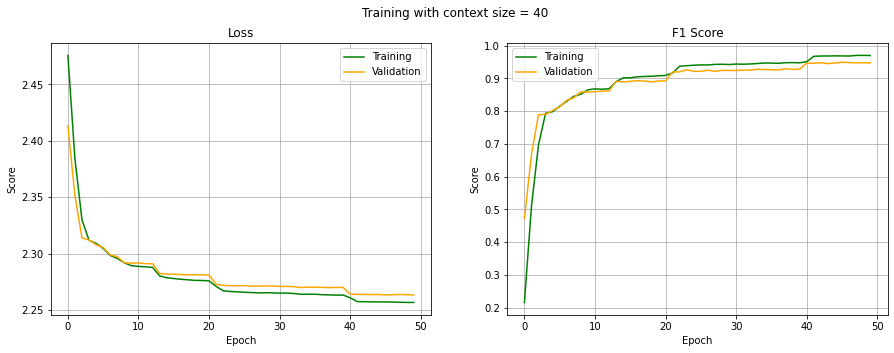

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9699, device='cuda:0'),
 tensor(0.9489, device='cuda:0'),
 tensor(0.9501, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9699, device='cuda:0'),
 tensor(0.9489, device='cuda:0'),
 tensor(0.9501, device='cuda:0'))

## Heatmap

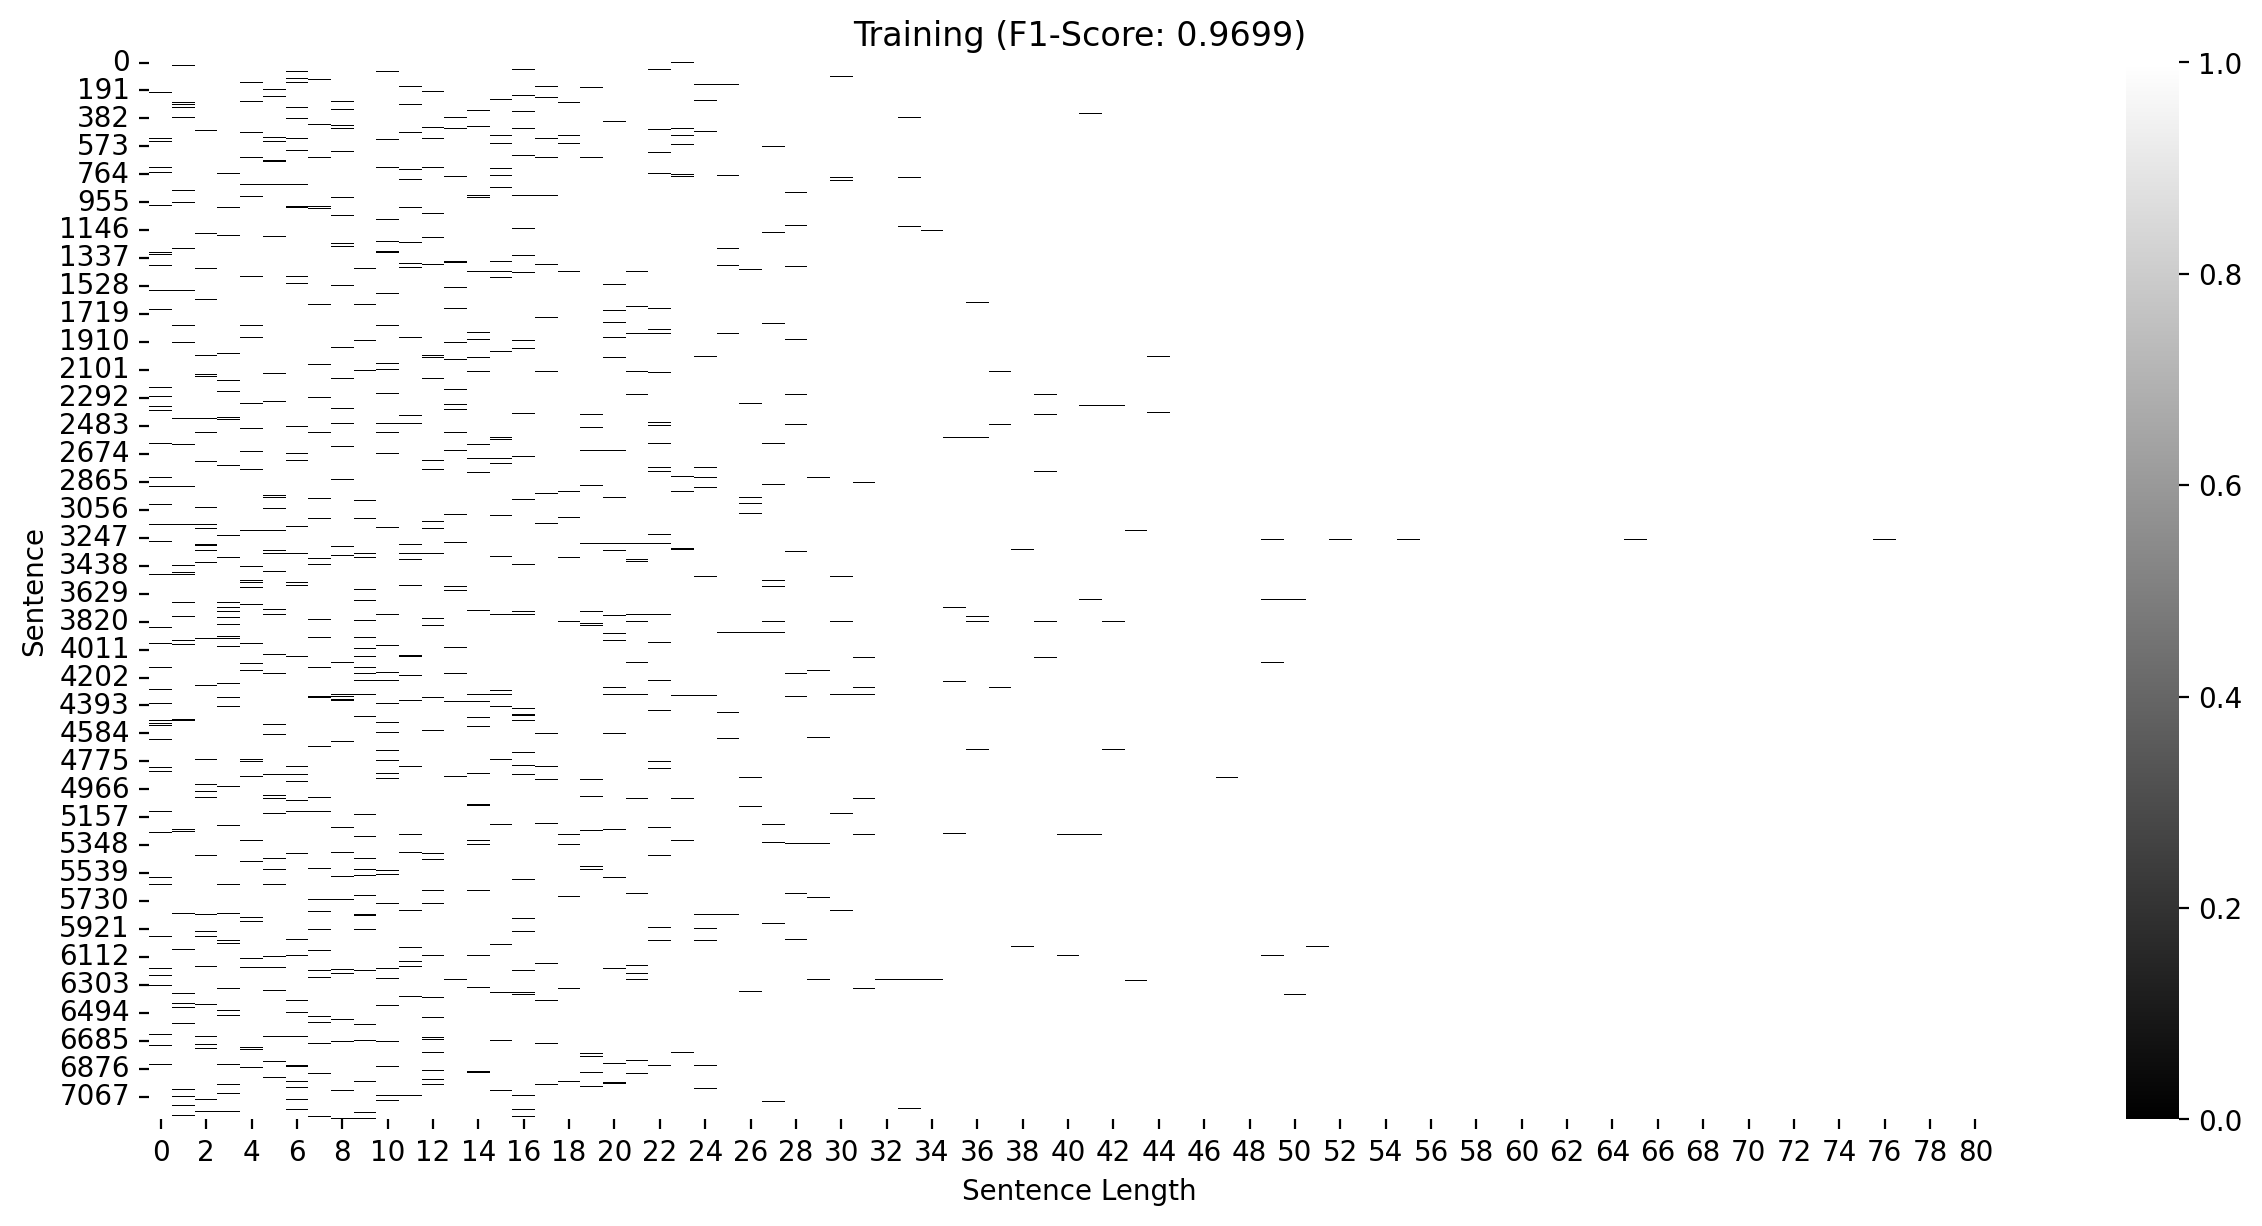

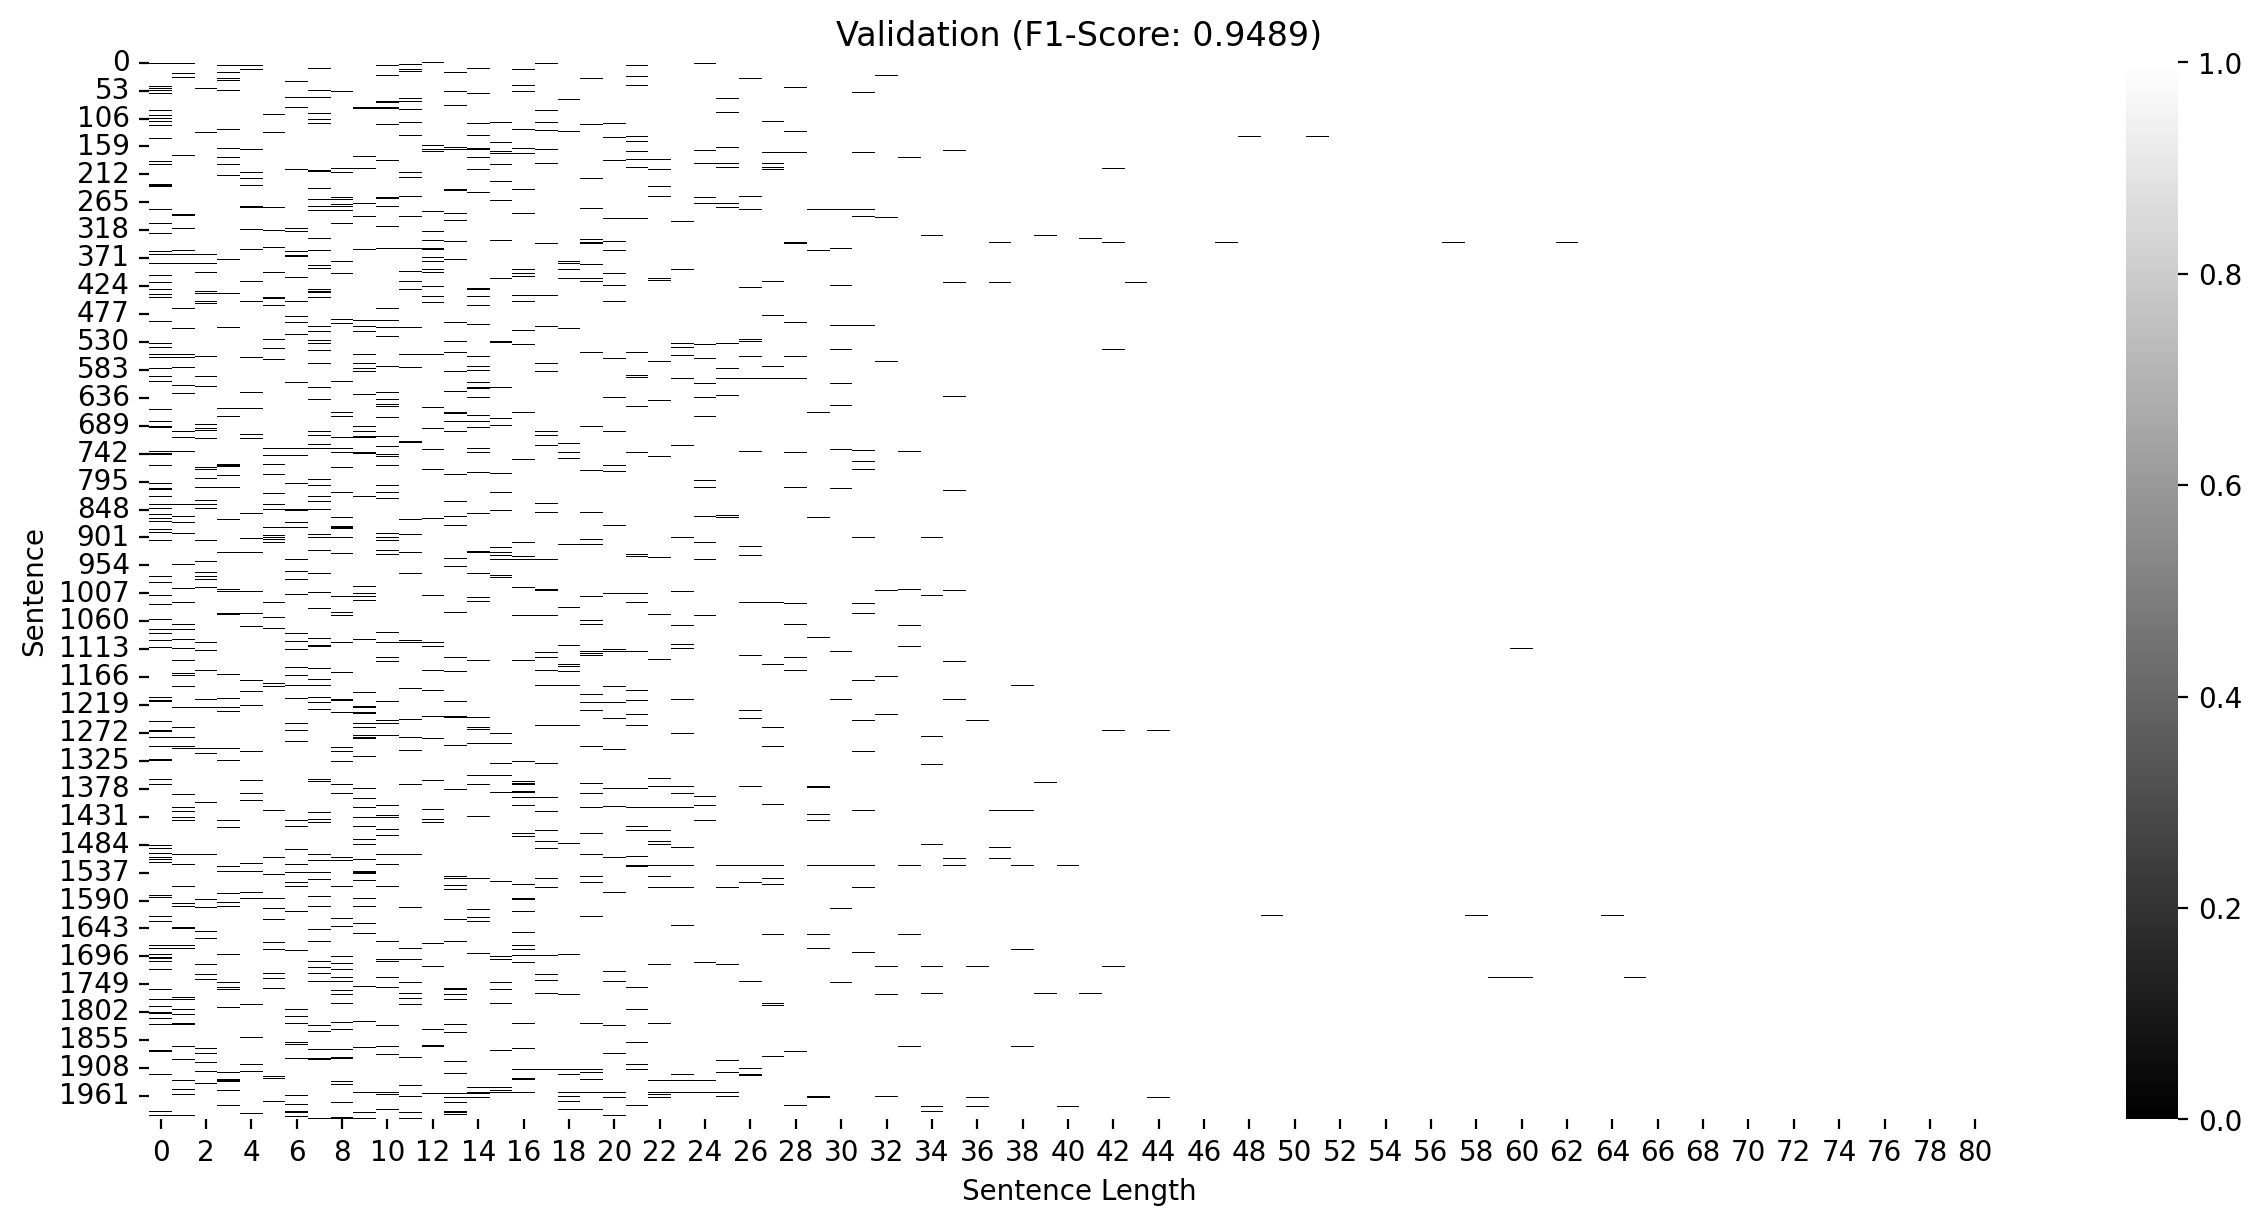

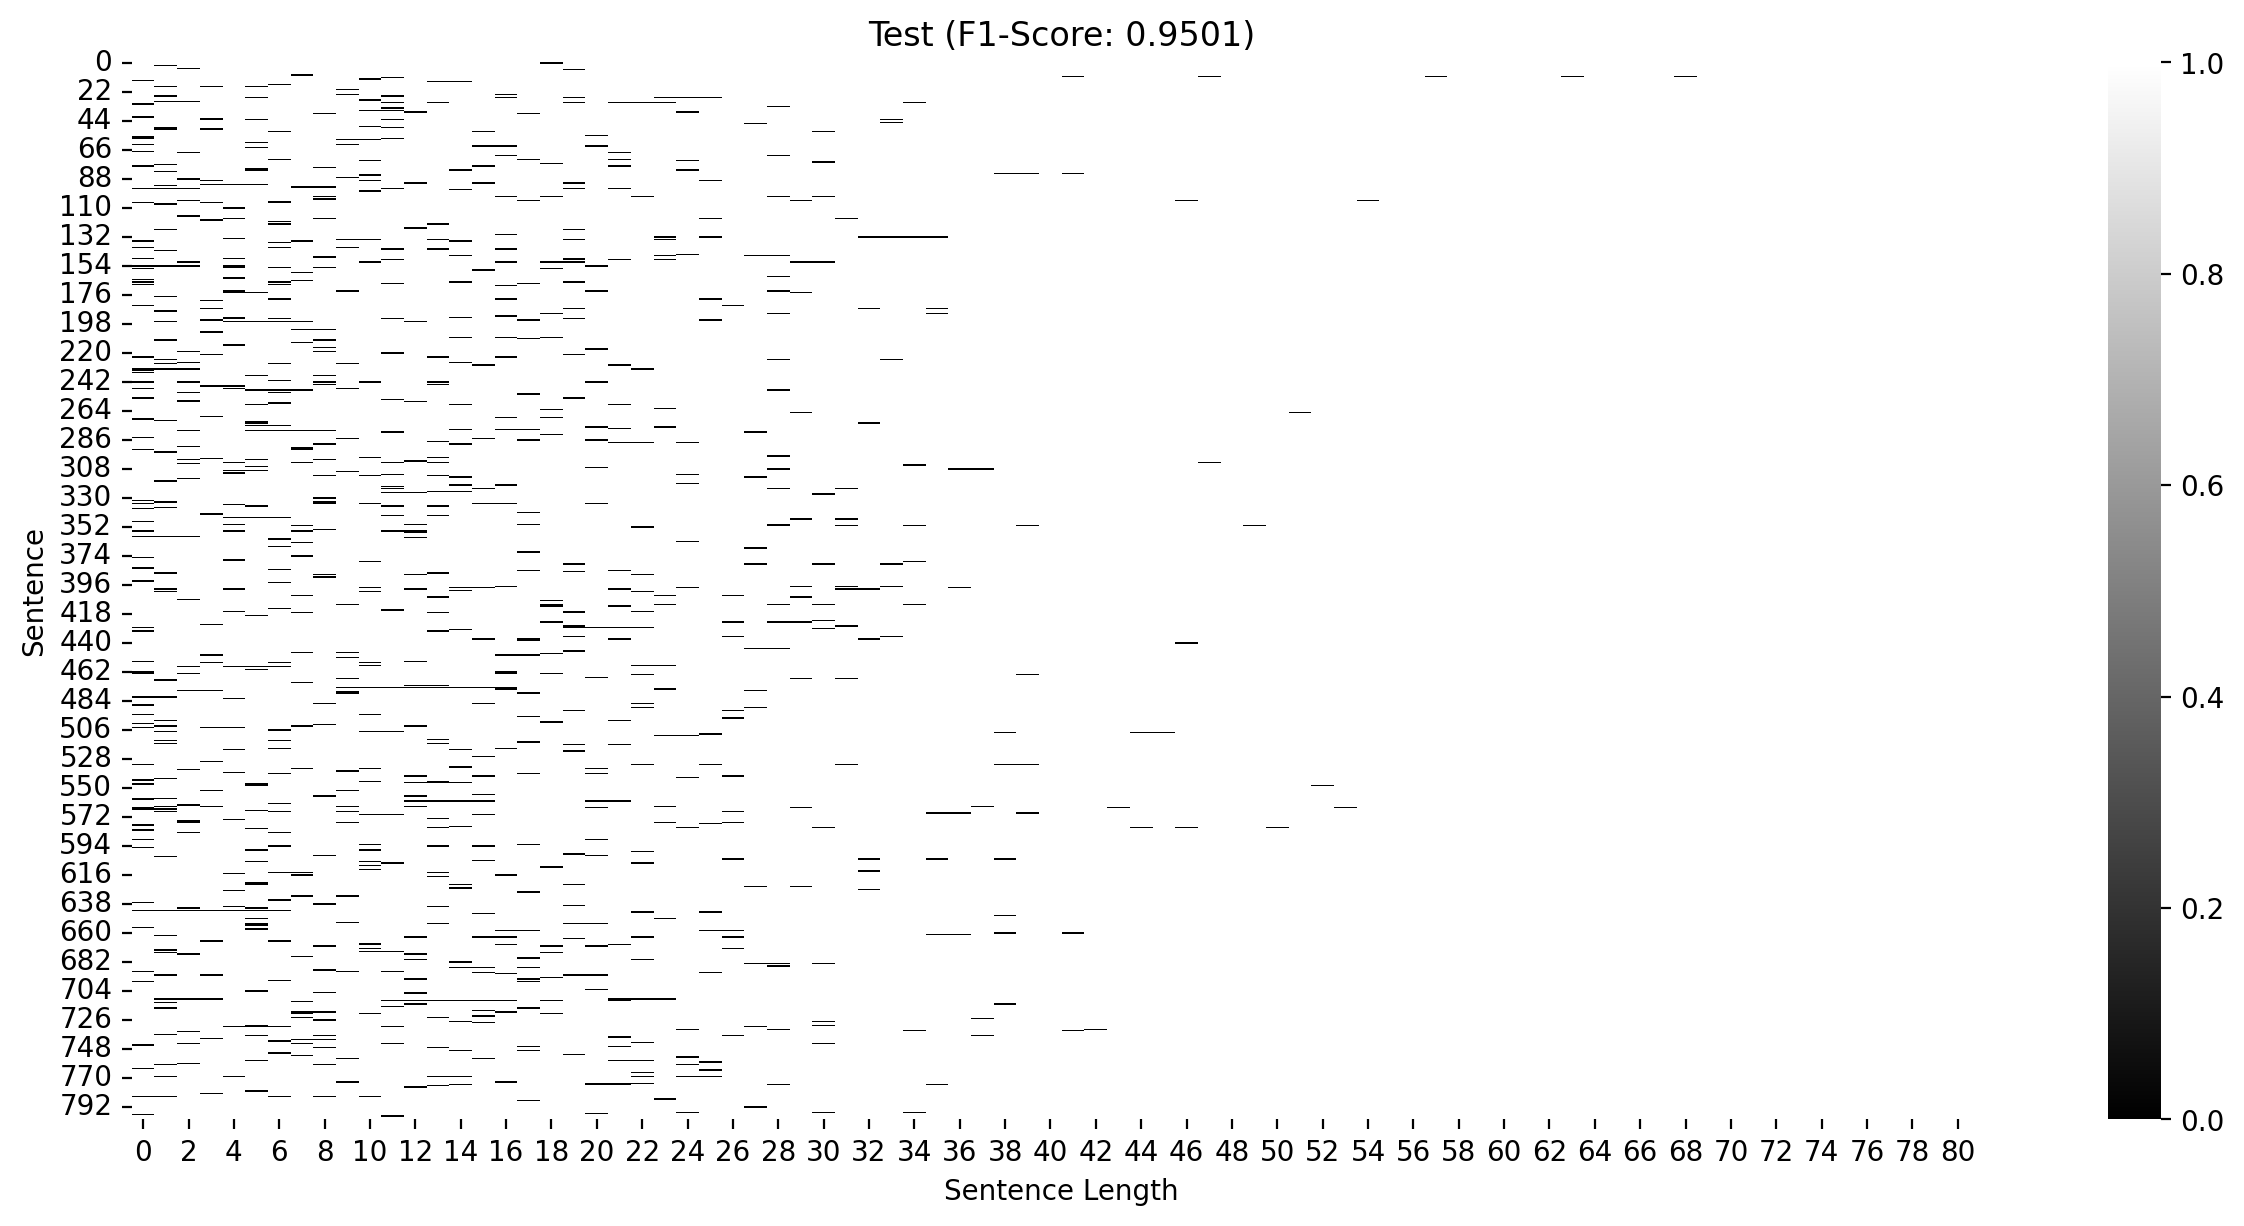

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


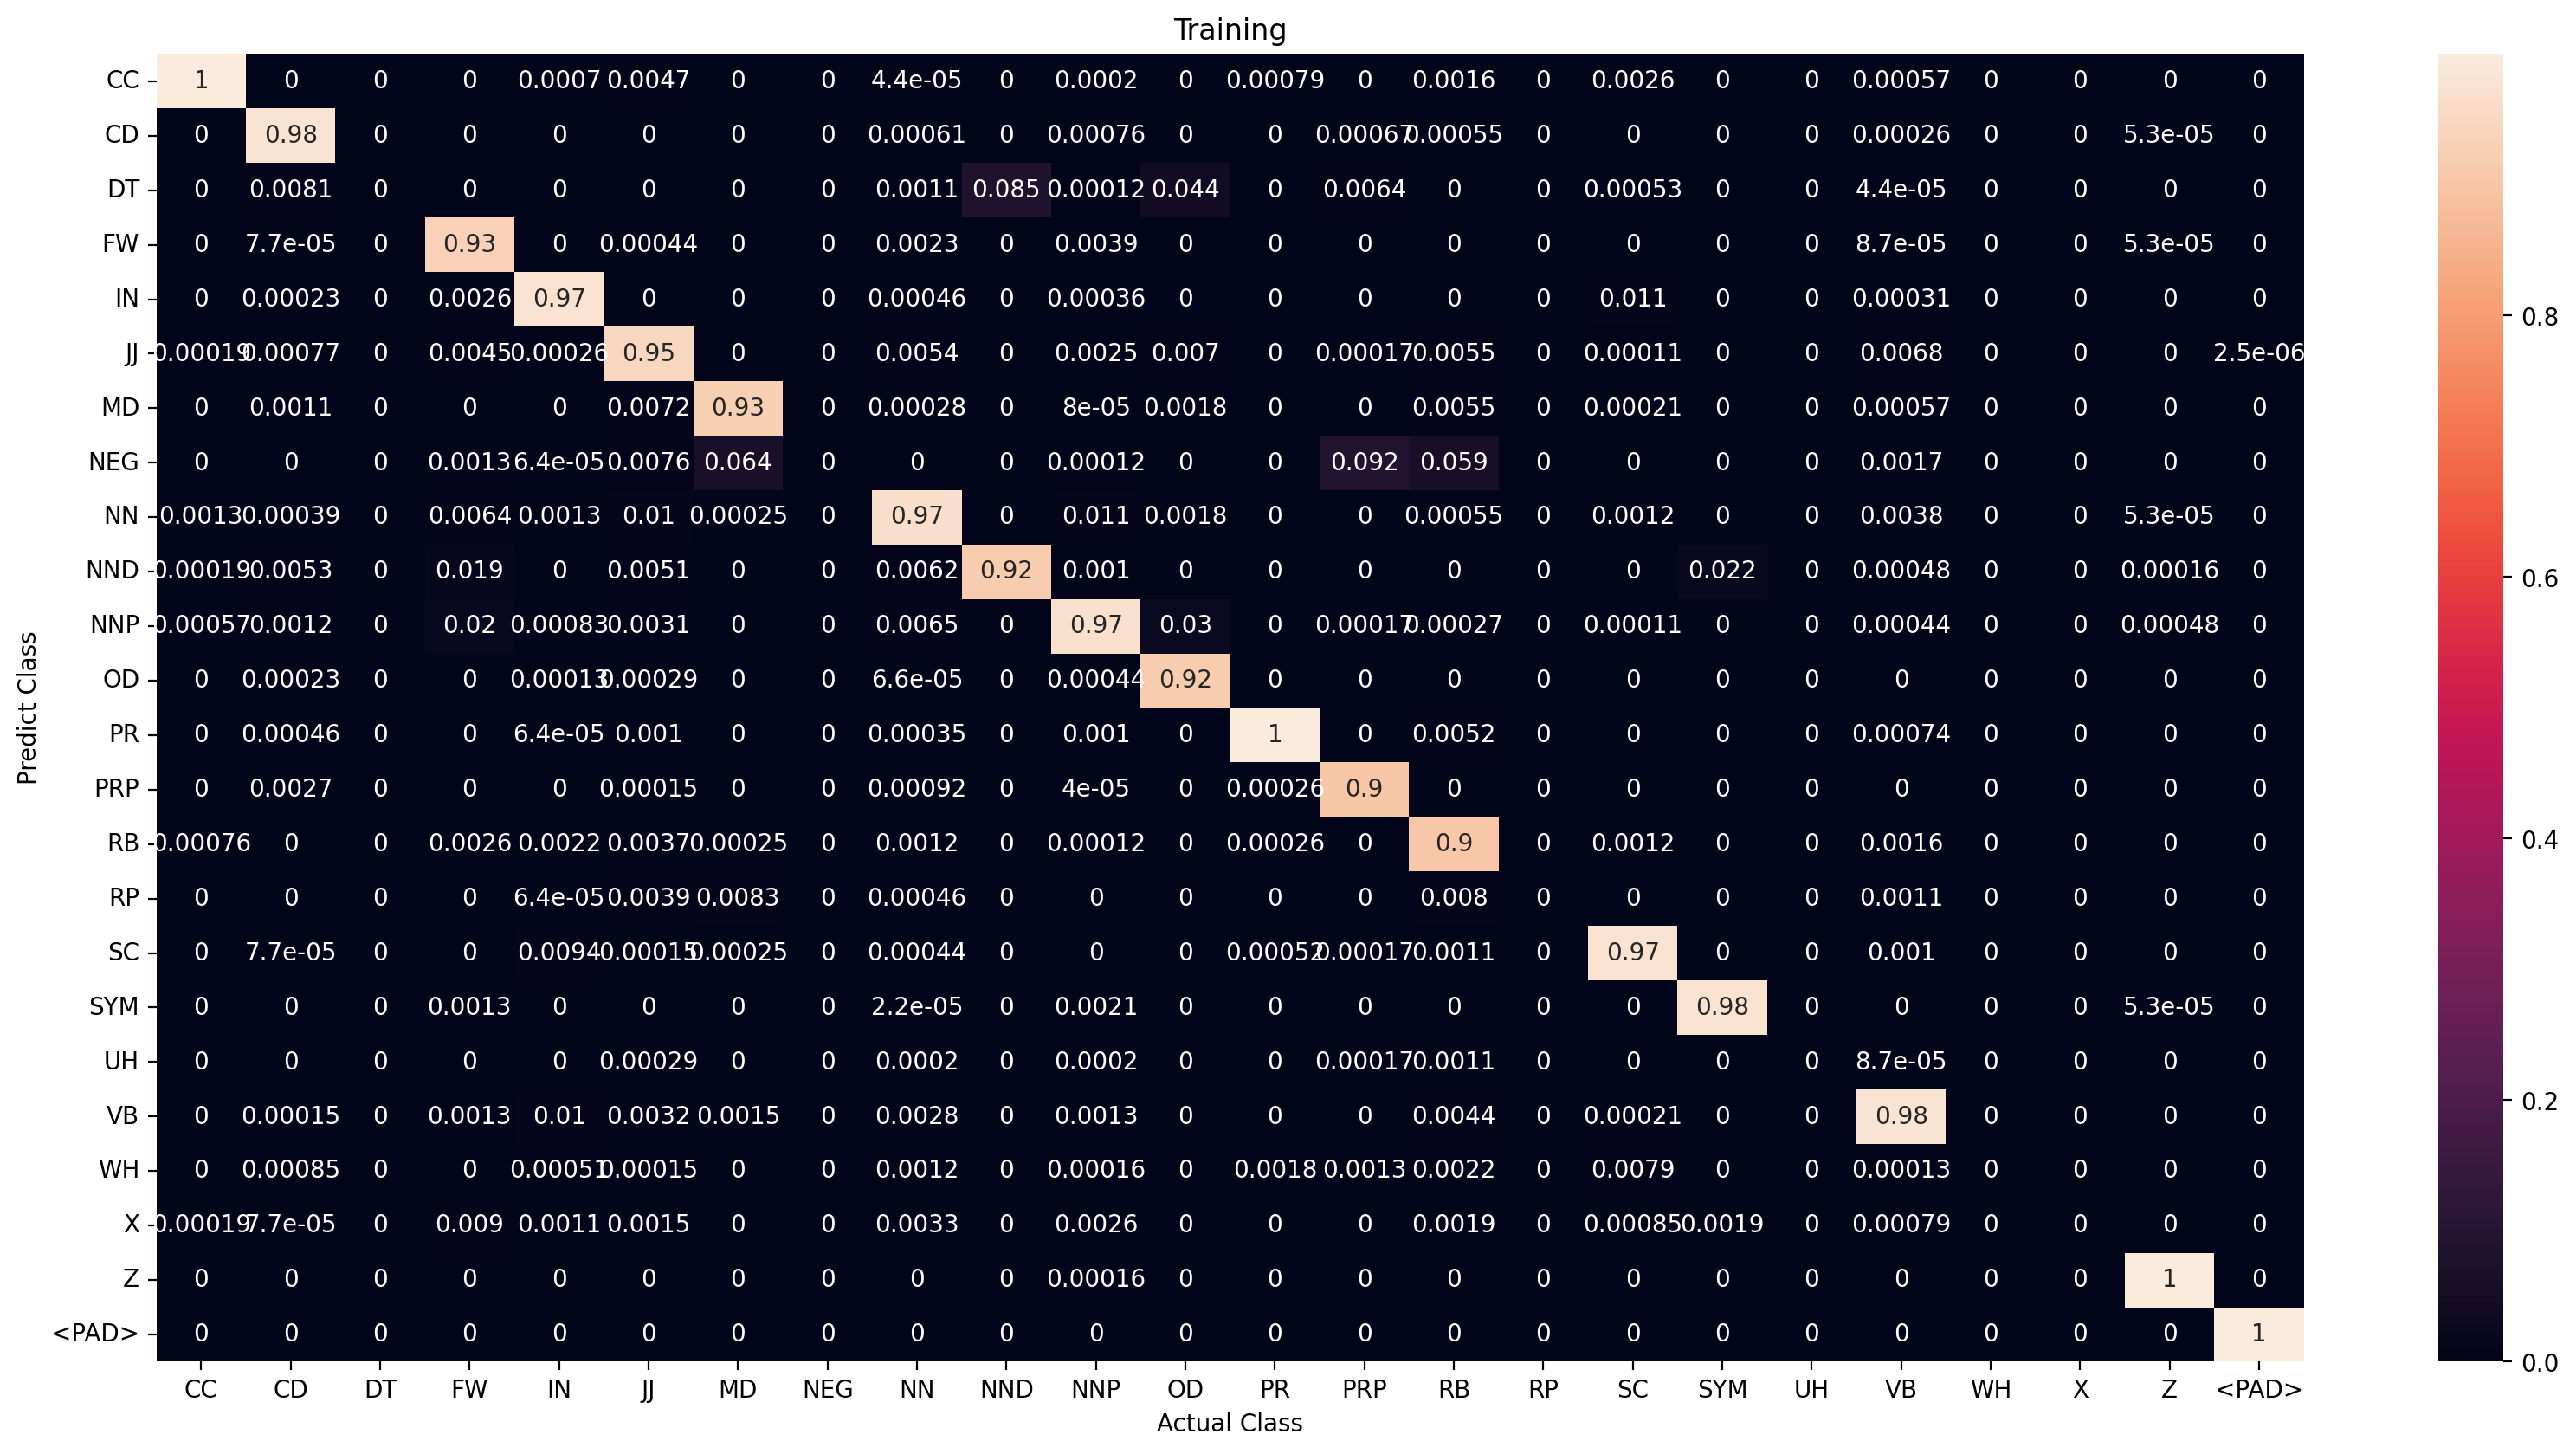

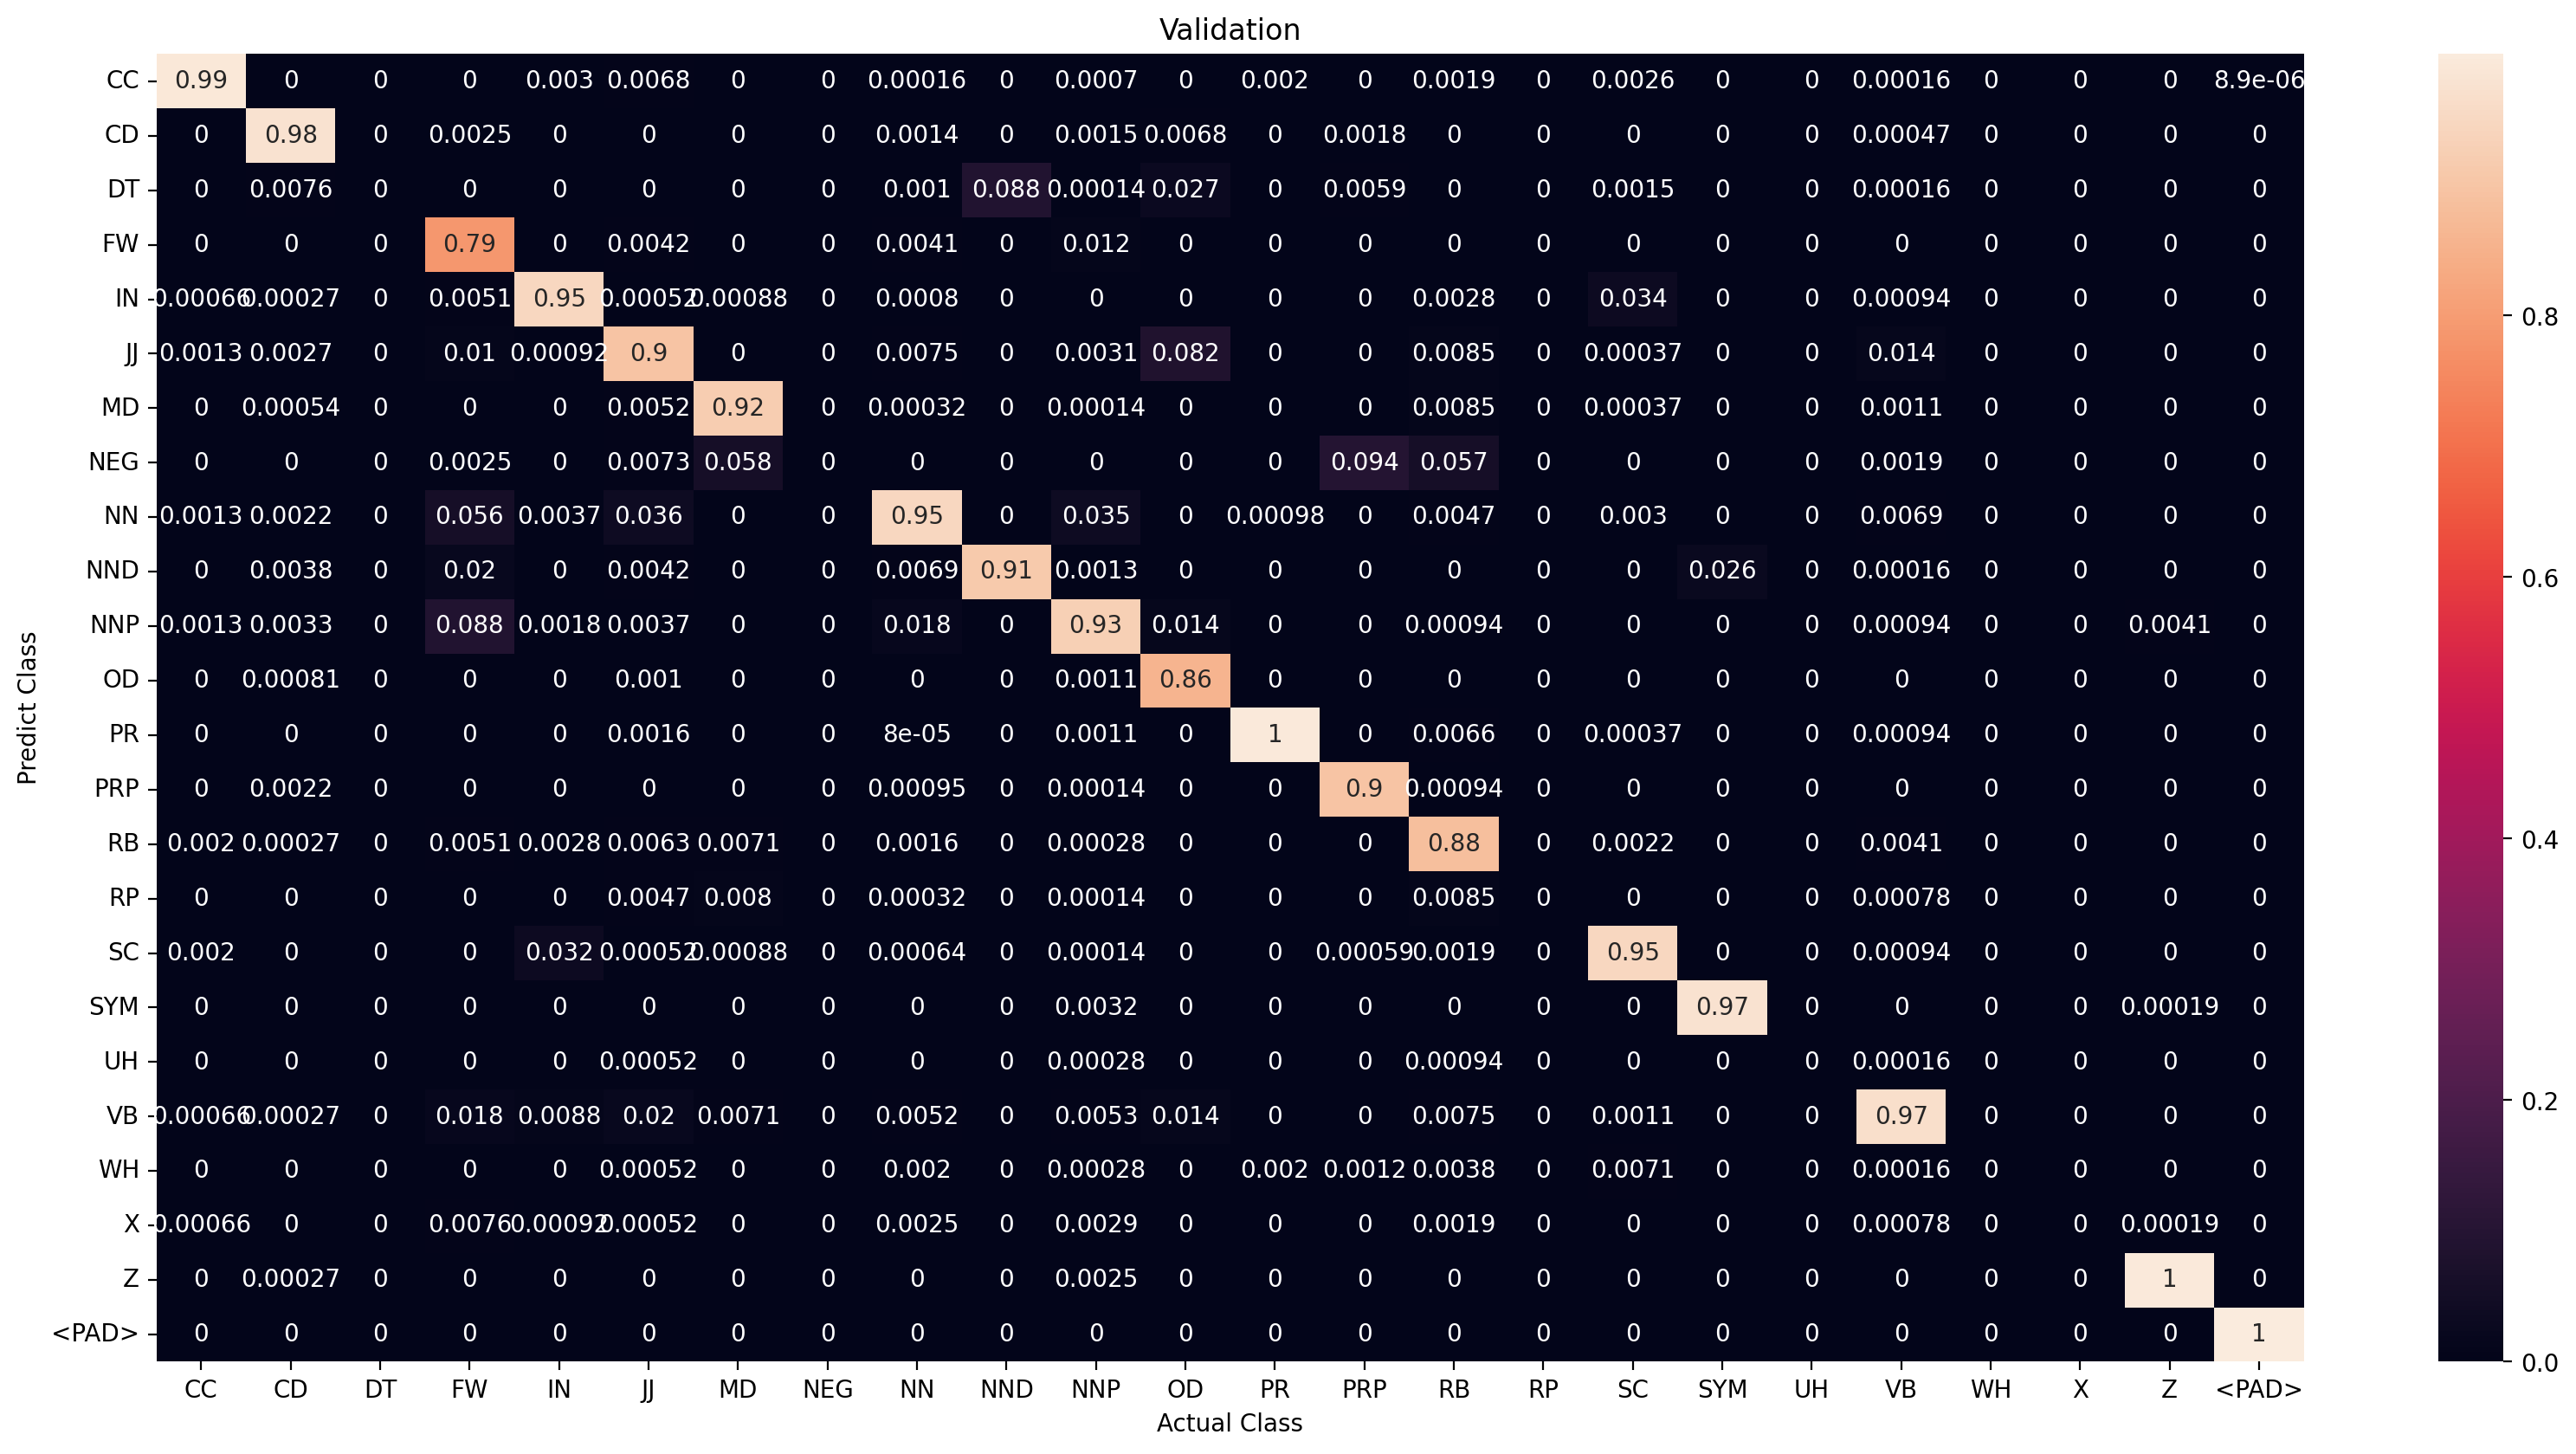

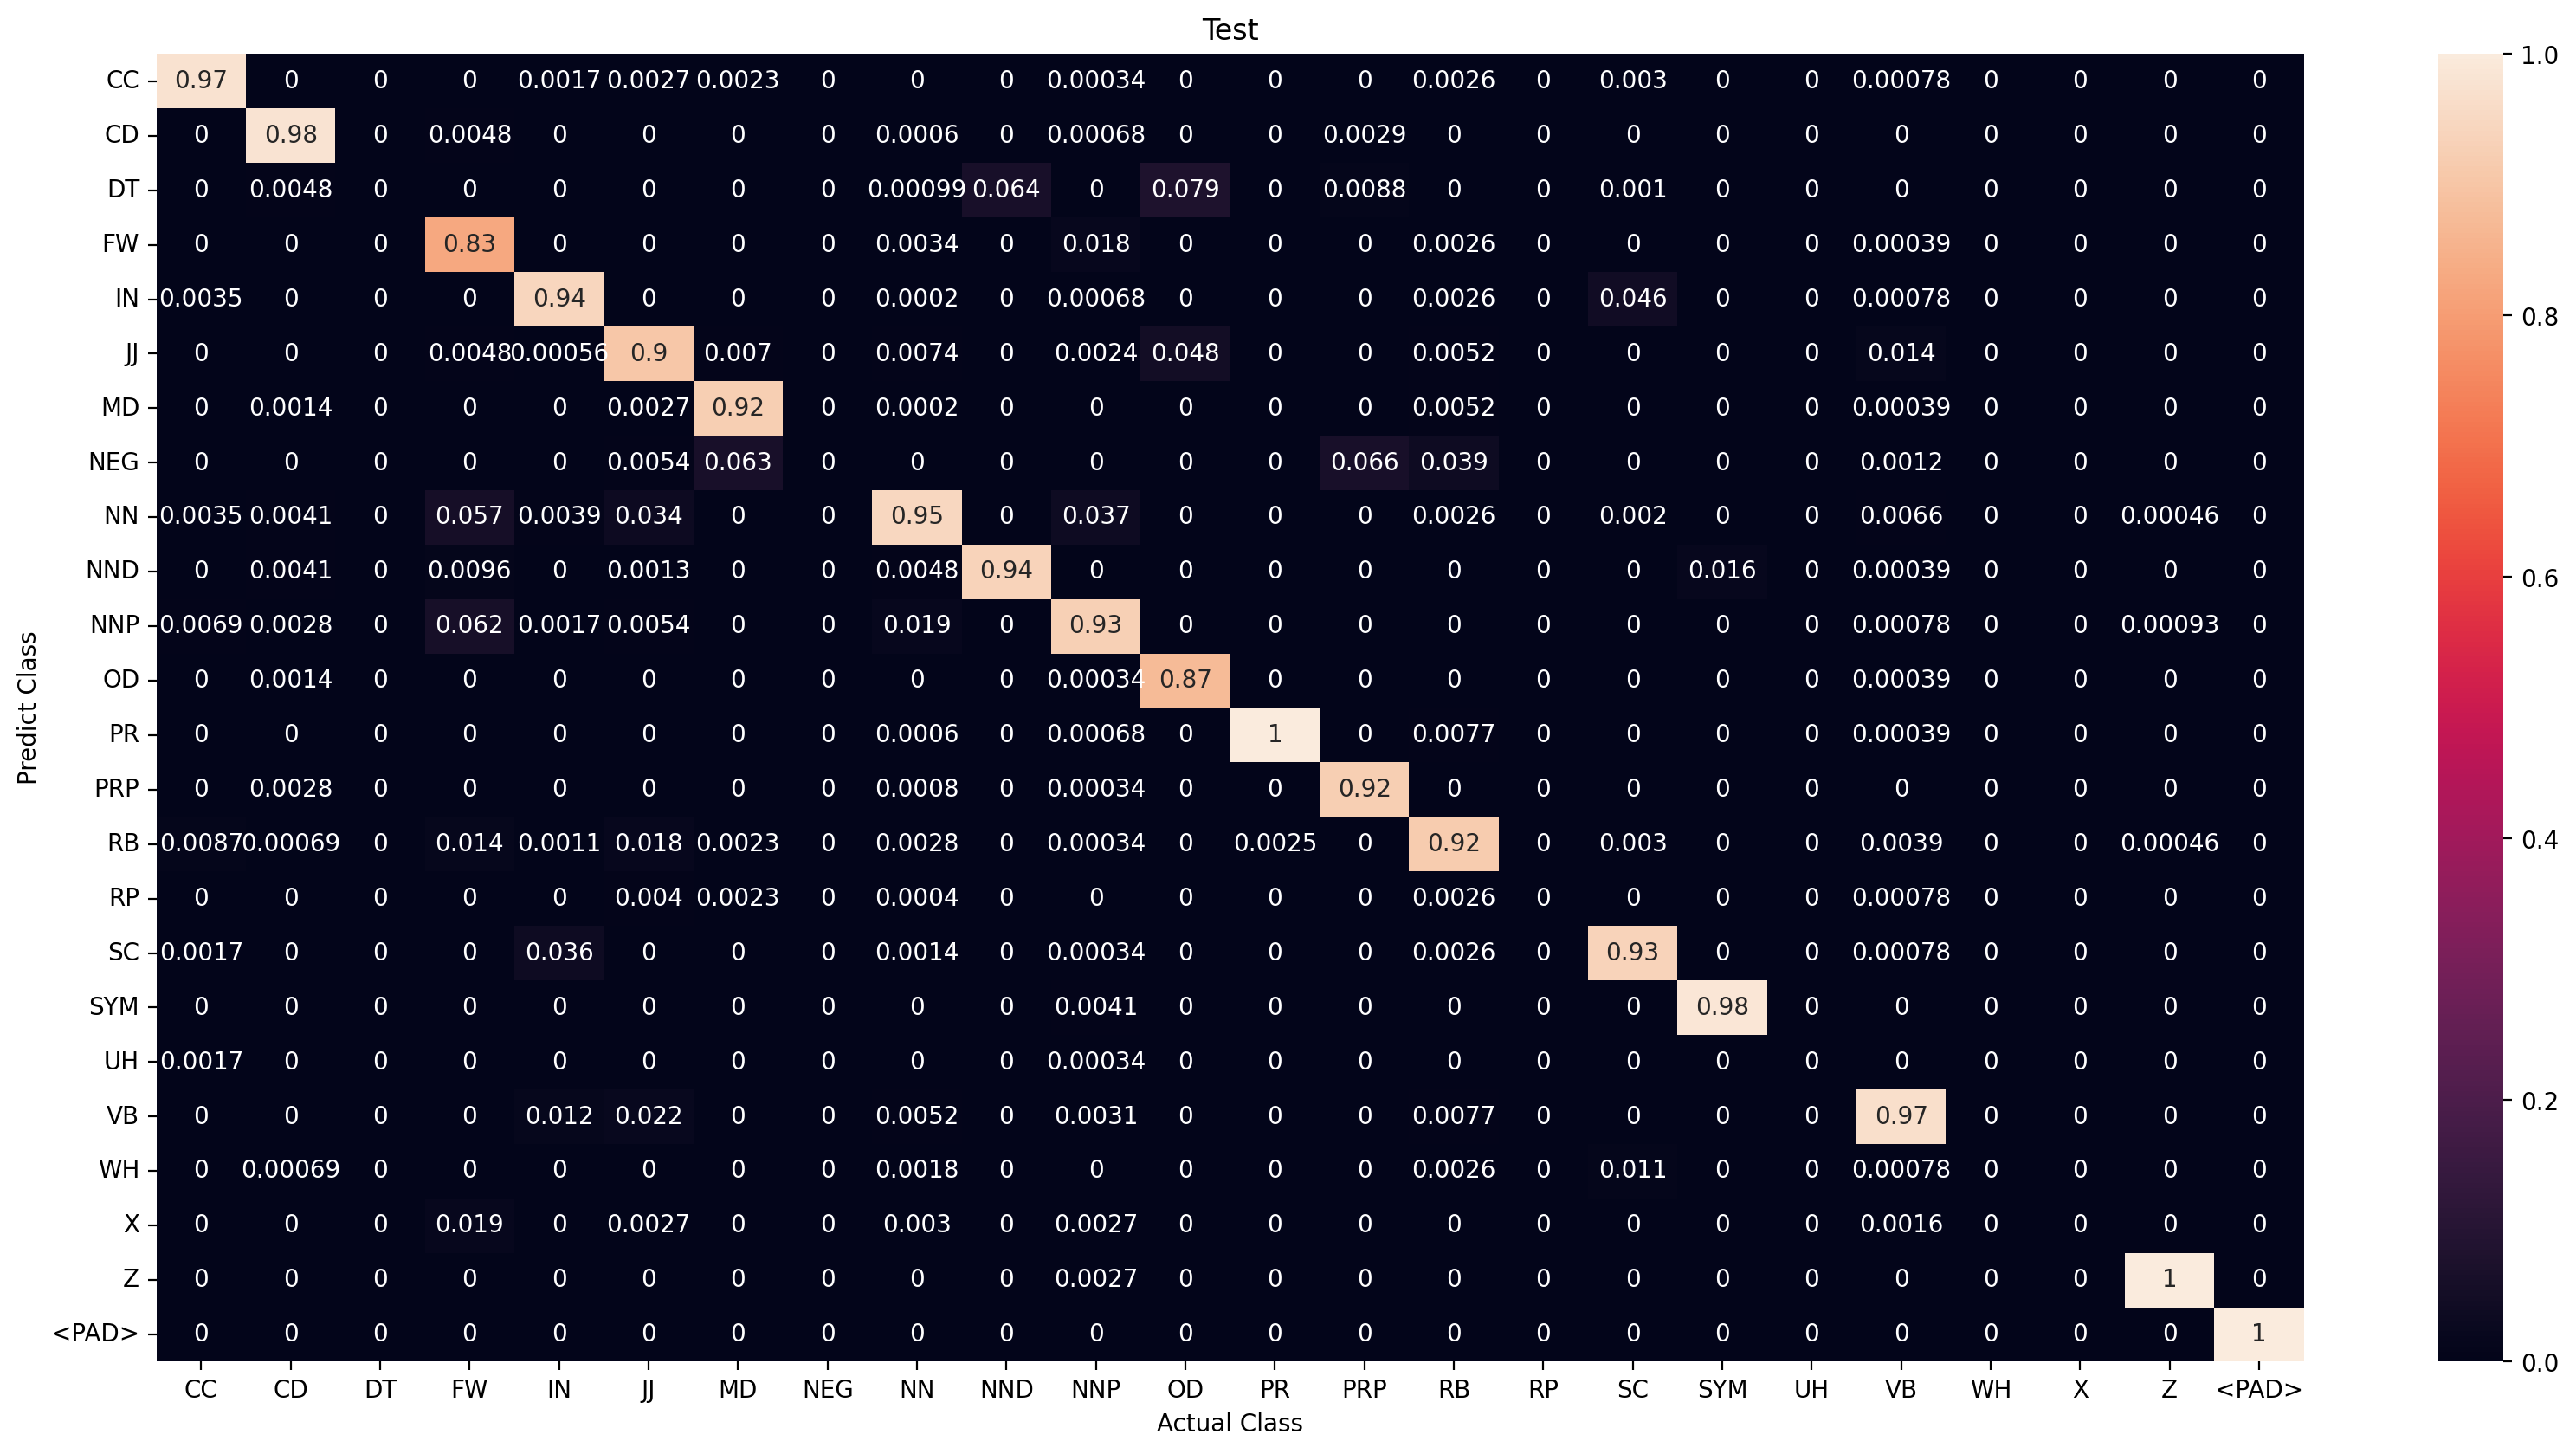

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5226       | CC    : 96       |
| CD    : 12758  | CD    : 12698      | CD    : 60       |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1458       | FW    : 208      |
| IN    : 15371  | IN    : 15222      | IN    : 149      |
| JJ    : 6997   | JJ    : 6480       | JJ    : 517      |
| MD    : 3774   | MD    : 3660       | MD    : 114      |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44187      | NN    : 485      |
| NND   : 1021   | NND   : 530        | NND   : 491      |
| NNP   : 24845  | NNP   : 24424      | NNP   : 421      |
| OD    : 541    | OD    : 520        | OD    : 21       |
| PR    : 3896   | PR    : 3805       | PR    : 91       |
| PRP   : 5408   | PRP   : 5328       | PRP   : 80       |
| RB    : 3463   | RB    : 3287       | RB    : 176      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11104
Wrong prediction            : 717
Percentage correct oov pred : 93.93452330598087

Validation
Number OOV token            : 3350
Correct prediction          : 2993
Wrong prediction            : 357
Percentage correct oov pred : 89.34328358208955

Test
Number OOV token            : 1391
Correct prediction          : 1263
Wrong prediction            : 128
Percentage correct oov pred : 90.79798705966931



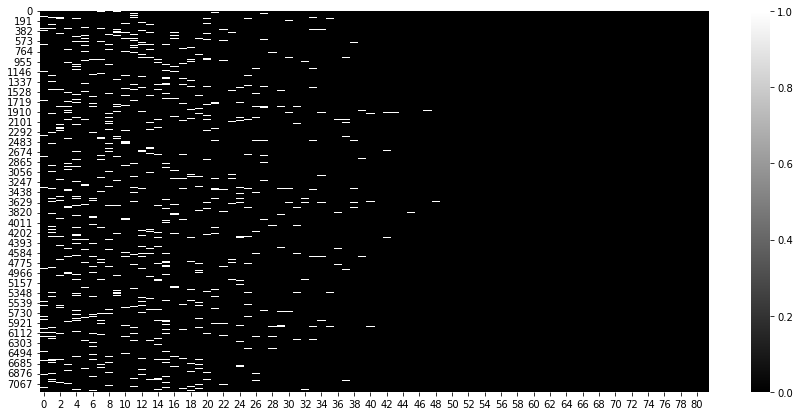

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

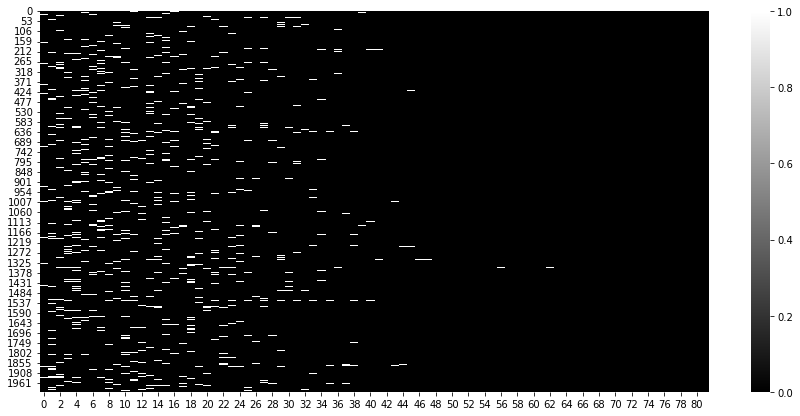

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

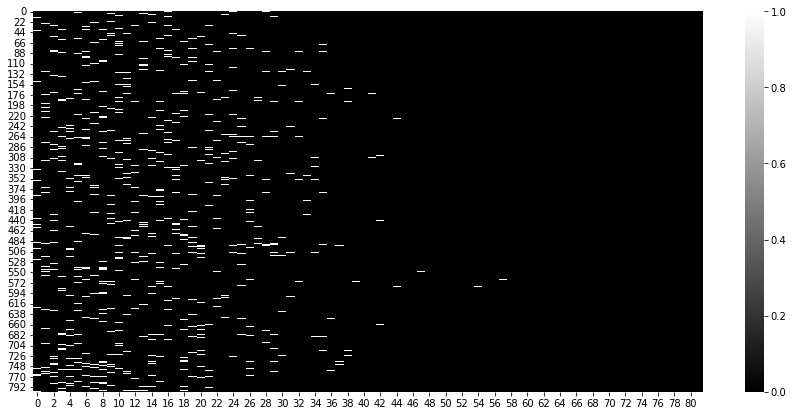

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);